In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 1
import os
from PIL import Image
import imageio
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!date

2018年 11月 12日 星期一 22:44:29 CST


In [13]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/prepare_weight/2018-11-10_01-20-15_noup'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
INFO:tensorflow:Restoring parameters from ../data/prepare_weight/2018-10-15_23-20-17_noup


# 初始化棋局

In [14]:
HUMAN_FIRST = False
MOVE = 'human' if HUMAN_FIRST else 'computer'

In [15]:
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
moves = []
#for i in moves[:]: 
#   statestr = GameBoard.sim_do_action(i,statestr)
#   imgs_for_gif.append(board_visualizer.get_board_img(statestr))
#   state.do_moae(i)
#mgs_for_gif = imgs_for_gif[:]
#mageio.mimsave('../data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

# 从这里开始下棋

In [16]:
assert(MOVE in ['human','computer'])
if MOVE == 'human':
    move = input()
    while (move not in GameBoard.get_legal_moves(statestr,current_player=state.currentplayer)):
        print("invalid move {}, please reinput:".format(move))
        move = input()
    MOVE = 'computer'
else:
    network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=1600,
                                           temp_round=-1,repeat_noise=False,c_puct=5,dnoise=True,is_selfplay=False)
    move = network_player.make_move(state=state,actual_move=False)[0]
    MOVE = 'human'
moves.append(move)

b2e2


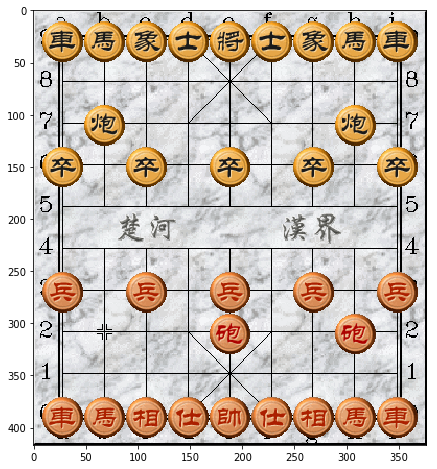

In [17]:
statestr = GameBoard.sim_do_action(move,statestr)
state.do_move(move)
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))
print(move)

# analysis

In [18]:
for move in network_player.mcts_policy._root._children:
    node = network_player.mcts_policy._root._children[move]
    print(move,node._n_visits,node._P,node._Q)

a0a1 0 2.8832019e-05 0
a0a2 0 2.0492085e-05 0
a3a4 0 9.308372e-06 0
b0a2 0 0.00015872167 0
b0c2 36 0.0048243497 0.015797126456163824
b2a2 0 5.1778887e-05 0
b2c2 0 0.00015000731 0
b2d2 0 4.666257e-05 0
b2e2 901 0.5200099 0.09442984999028808
b2f2 0 5.4467517e-05 0
b2g2 0 9.340621e-05 0
b2b1 0 1.6809487e-05 0
b2b3 0 9.601677e-05 0
b2b4 0 9.389348e-05 0
b2b5 0 3.0507908e-05 0
b2b6 0 4.1791413e-05 0
b2b9 0 9.4830284e-05 0
c3c4 0 2.3638579e-05 0
e0e1 0 2.8115296e-06 0
e3e4 0 4.042393e-05 0
g3g4 0 7.779535e-06 0
h0g2 0 6.7586785e-05 0
h0i2 0 9.067752e-06 0
h2c2 0 3.3301265e-05 0
h2d2 0 1.8165252e-05 0
h2e2 659 0.47140947 0.0117919814349993
h2f2 0 8.985524e-06 0
h2g2 1 0.00044225922 -0.015348659828305244
h2i2 0 4.582965e-05 0
h2h1 0 9.904402e-06 0
h2h3 0 5.7308944e-06 0
h2h4 0 2.100813e-05 0
h2h5 0 5.835211e-06 0
h2h6 0 7.774084e-06 0
h2h9 0 7.3620117e-06 0
i0i1 0 7.4954673e-06 0
i0i2 0 1.1862386e-05 0
i3i4 0 5.021706e-06 0
d0e1 0 3.1258234e-05 0
f0e1 0 1.4610951e-05 0
c0e2 2 0.0009110486 -0.0

In [19]:
network

((<tensorflow.python.client.session.Session at 0x7f2736c28e80>,
  <tensorflow.python.framework.ops.Graph at 0x7f282c08bcc0>),
 ((<tf.Tensor 'Placeholder:0' shape=(?, 10, 9, 14) dtype=float32>,
   <tf.Tensor 'training_mode:0' shape=<unknown> dtype=bool>),
  (<tf.Tensor 'concat_200:0' shape=(?, 2086) dtype=float32>,
   <tf.Tensor 'concat_201:0' shape=(?, 1) dtype=float32>)))

In [20]:
graph = network[0][1]
sess = network[0][0]

In [21]:
import tensorflow as tf
with graph.as_default():
    regularizer = tf.contrib.layers.l2_regularizer(scale=1e-4)
    regular_variables = tf.trainable_variables()
    l2_loss = tf.contrib.layers.apply_regularization(regularizer, regular_variables)

In [22]:
with graph.as_default():
    print(sess.run(l2_loss))

0.5401897
